# Load packages and probabilities from models

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

#load necessary data

df_notes_los = pd.read_csv('notes_with_los_probability.csv')
df_notes_los.loc[df_notes_los['los_icu_class'] == 'less than 3 days', 'los_icu_class'] = 0
df_notes_los.loc[df_notes_los['los_icu_class'] == 'greater than or equal to 3 days', 'los_icu_class'] = 1
df_notes_los['los_icu_class'] = pd.to_numeric(df_notes_los['los_icu_class'])
df_notes_los = df_notes_los[['long_stay_text', 'los_icu_class']]

df_TCN_los = pd.read_csv('tcn_probs_of_los_traintest.csv')
df_TCN_los = df_TCN_los.rename(columns={"probs": "TCN_los"})
df_LSTM_los = pd.read_csv('lstm_probs_of_los_traintest.csv')
df_LSTM_los = df_LSTM_los.rename(columns={"probs": "LSTM_los"})
df_XGB_los = pd.read_csv('XGB_probs_of_los_traintest.csv')
df_XGB_los = df_XGB_los.rename(columns={"probs": "XGB_los"})
df_RF_los = pd.read_csv('RF_probs_of_los_traintest.csv')
df_RF_los = df_RF_los.rename(columns={"probs": "RF_los"})


df_combined_los = pd.concat([df_notes_los, df_TCN_los, df_LSTM_los, df_XGB_los, df_RF_los],join='outer', axis=1)
df_combined_los

,long_stay_text,los_icu_class,TCN_los,LSTM_los,XGB_los,RF_los
0,0.638399,0,0.177666,0.362041,0.358053,0.595149
1,0.582376,1,0.248997,0.748051,0.361647,0.603065
2,0.402756,0,0.224803,0.839488,0.358053,0.595149
3,0.474346,1,0.170307,0.987397,0.361647,0.603065
4,0.403212,0,0.129668,0.202589,0.361647,0.603065
...,...,...,...,...,...,...
16317,0.374335,1,0.645344,0.790684,0.361647,0.603065
16318,0.517612,1,0.470154,0.863495,0.358053,0.595149
16319,0.087320,0,0.457594,0.538948,0.361647,0.603065
16320,0.262388,0,0.167702,0.128667,0.358053,0.595149


In [17]:
def plot_roc_curve(models, Xtest, ytest):
    plt.figure(figsize=(10,8))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             Xtest_tensor = torch.FloatTensor(Xtest)
#             with torch.no_grad():
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()
    
def eval_metrics(models, Xtest, ytest):
    res_df = []
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
            ypred = model.predict(Xtest)
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
            ypred = model.predict(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             with torch.no_grad():
#                 Xtest_tensor = torch.FloatTensor(Xtest)
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
#                 ypred = (ypred_proba >= 0.5).astype(int)

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)
        precision = precision_score(ytest, ypred, average='macro', zero_division=0)
        recall = recall_score(ytest, ypred, average='macro', zero_division=0)
        f1 = f1_score(ytest, ypred, average='macro', zero_division=0)

        result = pd.DataFrame({'AUROC':roc_auc,
                               'Precision':precision,
                               'Recall':recall,
                               'F1 Score':f1}, index=[model_name])
        res_df.append(result)
    
    final_df = pd.concat(res_df)
    return final_df

# Test various classifiers and stacking for death classification

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#comment out as required before running model

y_los = df_combined_los.pop('los_icu_class')

X_los = df_combined_los[["long_stay_text",
#         "TCN_los",
       "LSTM_los",
#        "XGB_los",
#         "RF_los"
       ]]



X_los_train, X_los_test, y_los_train, y_los_test = train_test_split(X_los, y_los, test_size=0.2, stratify=y_los, shuffle=True, random_state=42)

logR_los = LogisticRegression(random_state=42)
logR_los.fit(X_los_train, y_los_train)

GNB_los = GaussianNB()
GNB_los.fit(X_los_train, y_los_train)

RF_los = RandomForestClassifier(random_state=42)
RF_los.fit(X_los_train, y_los_train)

DecisionTree_los = DecisionTreeClassifier(random_state=42)
DecisionTree_los.fit(X_los_train, y_los_train)

estimators = []
estimators.append(('Logistic Regression Classifier', LogisticRegression(random_state=42) ))
estimators.append(('Gaussian Naive Bayes Classifier', GaussianNB() ))
estimators.append(('Random Forest Classifier', RandomForestClassifier(random_state=42) ))
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42) ))

logisticR = LogisticRegression(random_state=42)

SC_los = StackingClassifier(estimators=estimators,
                        final_estimator=logisticR,
                        cv=6,
                        #stack_method='predict_proba'
                       )
SC_los.fit(X_los_train, y_los_train)


StackingClassifier(cv=6,
                   estimators=[('Logistic Regression Classifier',
                                LogisticRegression(random_state=42)),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Random Forest Classifier',
                                RandomForestClassifier(random_state=42)),
                               ('Decision Tree Classifier',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

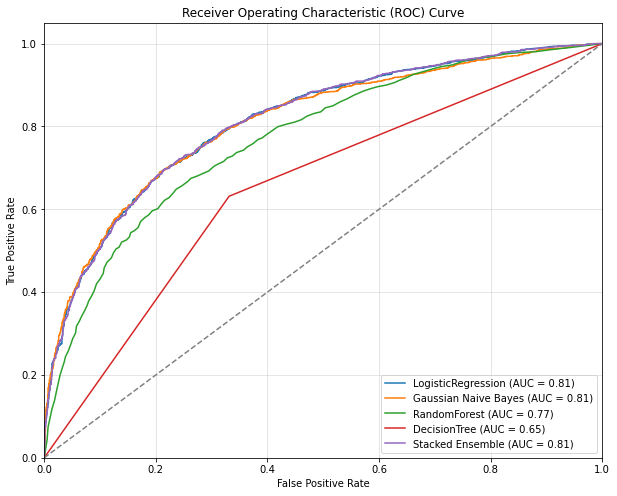

,AUROC,Precision,Recall,F1 Score
LogisticRegression,0.812503,0.741155,0.736749,0.737479
Gaussian Naive Bayes,0.809509,0.743275,0.736020,0.736748
RandomForest,0.771809,0.706300,0.704972,0.705343
DecisionTree,0.650052,0.649979,0.650052,0.650013
Stacked Ensemble,0.812543,0.742684,0.738847,0.739565


In [22]:
models_los = {'LogisticRegression':logR_los,
          'Gaussian Naive Bayes':GNB_los,
          'RandomForest':RF_los,
         'DecisionTree':DecisionTree_los,
         'Stacked Ensemble':SC_los}

# check model performance
plot_roc_curve(models_los, X_los_test, y_los_test)
eval_metrics(models_los, X_los_test, y_los_test)

# Best LOS predictor is Text_LSTM with logR, export model

In [69]:
import pickle

with open('ensb_logreg_los.pkl', 'wb') as file:
    pickle.dump(logR_los, file)